# 1. Extract data

>1|0<br>
AAYLLAKINLKALAALAKKIL<br>
>2|0<br>
AEKVDPVKLNLTLSAAAEALTGLGDK<br>
>3|0<br>
AGYLLGKINLKALAALAKKIL<br>
...<br>
>372|1<br>
TKKDLTQWFFKITDYADELLDKLD<br>
>373|1<br>
SGWNAYIDTMTAAAP<br>

In [ ]:
# import pandas as pd

# filename = 'CPP.txt'
# x = []
# y = []
# with open(filename) as f:
#     for index,line in enumerate(f.readlines()):
#         if(index%2==0):
#             label = int(line.split('|')[1])
#             y.append(label)
        
#         else:
#             x.append(line.strip('\n'))

# c={"Seqs" : x,
#    "Label" : y}
# cppdata=pd.DataFrame(c)
# cppdata.to_csv("CPP.csv",index=False)
# cppdata.head()

,Seqs,Label
0,AAAAARRRIRKQAHAHSK,1
1,ADVFDRGGPYLQRGVADLVPTATLLDTYSP,1
2,AGCKNFFWKTFTSC,1
3,AGYLLGKLKALAALAKKIL,1
4,AHALCLTERQIKSNRRMKWKKEN,1


In [1]:
import pandas as pd

cppdata = pd.read_csv('train_.csv')

cppdata.head(1)

,Seqs,Label
0,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


# 2. Divide training set and test set



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# create train and test set 
kf = KFold(n_splits=10,shuffle=True)
a= 0
for train, test in kf.split(cppdata):
  a=a+1 
  temptrain = cppdata.iloc[train]
  temptest = cppdata.iloc[test]
  temptrain.to_csv("train%d.csv" %a, index=False)
  temptest.to_csv("test%d.csv" %a, index=False)
# train, test = train_test_split(cppdata, test_size=0.1)
# train.to_csv("train.csv", index=False)
# test.to_csv("test.csv", index=False)

# 3. Preprocess


In [3]:
# import spacy
import torch
from torchtext import data, datasets  # .legacy
from torchtext.vocab import Vectors
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [4]:
# spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)

"""
field在默认的情况下都期望一个输入是一组单词的序列，并且将单词映射成整数。
这个映射被称为vocab。如果一个field已经被数字化了并且不需要被序列化，
可以将参数设置为use_vocab=False以及sequential=False。
"""
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer,fix_length=45)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [5]:
train,val,test = data.TabularDataset.splits(
        path='.', train='train_.csv',validation='val_.csv',test='test_.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])


/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [6]:
print(train[5])
print(train[5].__dict__.keys())
print(train[5].Seqs,train[5].Label)

dict_keys(['Seqs', 'Label'])
['H', 'H', 'C', 'A', 'R', 'Q', 'R', 'L', 'R'] 0


In [7]:
TEXT.build_vocab(train,val,test)

In [8]:
print(TEXT.vocab.itos[1])
print(TEXT.vocab.stoi['N'])


<pad>
15


In [9]:
train_iter = data.BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

val_iter = data.BucketIterator(val, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

test_iter = data.BucketIterator(val, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)



/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# 4. Define the model

In [10]:
epsilon = 0.00000001
def squash(x):
    # not concern batch_size, maybe rewrite
    s_squared_norm = torch.sum(x*x,1,keepdim=True) + epsilon
    scale = torch.sqrt(s_squared_norm)/(1. + s_squared_norm)
    # out = (batch_size,1,10)*(batch_size,16,10) = (batch_size,16,10)
    out = scale * x
    return out


In [11]:
class Capsule(nn.Module):

    def __init__(self, in_units,in_channels, num_capsule, dim_capsule, routings=3, **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.in_units = in_units
        self.in_channels = in_channels
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        # (in_units,10,128,16)
        self.W = nn.Parameter((torch.randn(self.in_units,self.num_capsule,self.in_channels, self.dim_capsule)))

    def forward(self, u_vecs):
        u_vecs = u_vecs.permute(0,2,1)
        u_vecs = u_vecs.unsqueeze(2)
        u_vecs = u_vecs.unsqueeze(2)

        
        # (batch_size,in_units,1,1,in_channels)*(in_units,10,in_channels,16) = (batch_size,in_units,10,1,16)
        u_hat_vecs = torch.matmul(u_vecs,self.W)
        # (batch_size,in_units,10,16)
        u_hat_vecs = u_hat_vecs.permute(0,1,2,4,3).squeeze(4)
        
        # (batch_size,10,in_units,16)
        u_hat_vecs2 = u_hat_vecs.permute(0,2,1,3)
    
        # (batch_size,10,1,in_units)
        b = torch.zeros(u_hat_vecs.size(0),self.num_capsule,1,self.in_units,device=DEVICE)
        for i in range(self.routings):
            # (batch_size,10,1,in_units)
            c = F.softmax(b,-1)
            # s = (batch_size,10,1,in_units)*(batch_size,10,in_units,16) = (batch_size,10,1,16)
            s = torch.matmul(c,u_hat_vecs2)
            # (batch_size,16,10)
            s = s.permute(0,3,1,2).squeeze(3)
            # (batch_size,16,10)
            v = squash(s)
            # here
            # (batch_size,10,16,1)
            v = v.permute(0,2,1).unsqueeze(3)
            # (batch_size,10,in_units,16)*(batch_size,10,16,1) = (batch_size,10,in_units,1)
            sim = torch.matmul(u_hat_vecs2,v)
            # (batch_size,10,1,in_units)
            sim = sim.permute(0,1,3,2)
            b = b+sim
        # (batch_size,16,10)
        return v.permute(0,2,1,3).squeeze(3)

In [12]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [13]:
len_vocab = len(TEXT.vocab)
embed_size=20
n_class=2
n_hidden =32

energy = [
[-1.65,  -2.83, 1.16,	1.80,	-3.73,	-0.41,	1.90,	-3.69,	0.49,	-3.01,	-2.08,	0.66,	1.54,	1.20,	0.98, -0.08,  0.46, -2.31,	0.32,	-4.62],
[-2.83,	-39.58,	-0.82,	-0.53,	-3.07,	-2.96,	-4.98,	0.34,	-1.38,	-2.15,	1.43,	-4.18,	-2.13,	-2.91,	-0.41,	-2.33,	-1.84,	-0.16,	4.26,	-4.46],
[1.16,	-0.82,	0.84,	1.97,	-0.92,	0.88,	-1.07,	0.68,	-1.93,	0.23,	0.61,	0.32,	3.31,	2.67,	-2.02,	0.91,	-0.65,	0.94,	-0.71,	0.90],
[1.80,	-0.53,	1.97,	1.45,	0.94,	1.31,	0.61,	1.30,	-2.51,	1.14,	2.53,	0.20,	1.44,	0.10,	-3.13,	0.81,	1.54,	0.12,	-1.07,	1.29],
[-3.73,	-3.07,	-0.92,	0.94,	-11.25,	0.35,	-3.57,	-5.88,	-0.82,	-8.59,	-5.34,	0.73,	0.32,	0.77,	-0.40,	-2.22,	0.11,	-7.05,	-7.09,	-8.80],
[-0.41,	-2.96,	0.88,	1.31,	0.35,	-0.20,	1.09,	-0.65,	-0.16,	-0.55,	-0.52,	-0.32,	2.25,	1.11,	0.84,	0.71,	0.59,	-0.38,	1.69,	-1.90],
[1.90,	-4.98,	-1.07,	0.61,	-3.57,	1.09,	1.97,	-0.71,	2.89,	-0.86,	-0.75,	1.84,	0.35,	2.64,	2.05,	0.82,	-0.01,	0.27,	-7.58,	-3.20],
[-3.69,	0.34,	0.68,	1.30,	-5.88,	-0.65,	-0.71,	-6.74,	-0.01,	-9.01,	-3.62,	-0.07,	0.12,	-0.18,	0.19,	-0.15,	0.63,	-6.54,	-3.78,	-5.26],
[0.49,	-1.38,	-1.93,	-2.51,	-0.82,	-0.16,	2.89,	-0.01,	1.24,	0.49,	1.61,	1.12,	0.51,	0.43,	2.34,	0.19,	-1.11,	0.19,	0.02,	-1.19],
[-3.01,	-2.15,	0.23,	1.14,	-8.59,	-0.55,	-0.86,	-9.01,	0.49,	-6.37,	-2.88,	0.97,	1.81,	-0.58,	-0.60,	-0.41,	0.72,	-5.43,	-8.31,	-4.90],
[-2.08,	1.43,	0.61,	2.53,	-5.34,	-0.52,	-0.75,	-3.62,	1.61,	-2.88,	-6.49,	0.21,	0.75,	1.90,	2.09,	1.39,	0.63,	-2.59,	-6.88,	-9.73],
[0.66,	-4.18,	0.32,	0.20,	0.73,	-0.32,	1.84,	-0.07,	1.12,	0.97,	0.21,	0.61,	1.15,	1.28,	1.08,	0.29,	0.46,	0.93,	-0.74,	0.93],
[1.54,	-2.13,	3.31,	1.44,	0.32,	2.25,	0.35,	0.12,	0.51,	1.81,	0.75,	1.15,	-0.42,	2.97,	1.06,	1.12,	1.65,	0.38,	-2.06,	-2.09],
[1.20,	-2.91,	2.67,	0.10,	0.77,	1.11,	2.64,	-0.18,	0.43,	-0.58,	1.90,	1.28,	2.97,	-1.54,	0.91,	0.85,	-0.07,	-1.91,	-0.76,	0.01],
[0.98,	-0.41,	-2.02,	-3.13,	-0.40,	0.84,	2.05,	0.19,	2.34,	-0.60,	2.09,	1.08,	1.06,	0.91,	0.21,	0.95,	0.98,	0.08,	-5.89,	0.36],
[-0.08,	-2.33,	0.91,	0.81,	-2.22,	0.71,	0.82,	-0.15,	0.19,	-0.41,	1.39,	0.29,	1.12,	0.85,	0.95,	-0.48,	-0.06,	0.13,	-3.03,	-0.82],
[0.46,	-1.84,	-0.65,	1.54,	0.11,	0.59,	-0.01,	0.63,	-1.11,	0.72,	0.63,	0.46,	1.65,	-0.07,	0.98,	-0.06,	-0.96,	1.14,	-0.65,	-0.37],
[-2.31,	-0.16,	0.94,	0.12,	-7.05,	-0.38,	0.27,	-6.54,	0.19,	-5.43,	-2.59,	0.93,	0.38,	-1.91,	0.08,	0.13,	1.14,	-4.82,	-2.13,	-3.59],
[0.32,	4.26,	-0.71,	-1.07,	-7.09,	1.69,	-7.58,	-3.78,	0.02,	-8.31,	-6.88,	-0.74,	-2.06,	-0.76,	-5.89,	-3.03,	-0.65,	-2.13,	-1.73,	-12.39],
[-4.62,	-4.46,	0.90,	1.29,	-8.80,	-1.90,	-3.20,	-5.26,	-1.19,	-4.90,	-9.73,	0.93,	-2.09,	0.01,	0.36,	-0.82,	-0.37,	-3.59,	-12.39,	-2.68],
]

physicochemical = [
    [-0.4, -0.5, 15, 8.1, 0.046, 0.67, 1.28, 0.3, 0, 0.687, 115, 0.28, 154.330012, 27.5, 1.181, 0.0072,0,0,0,0],
    [0.17, -1, 47, 5.5, 0.128, 0.38, 1.77, 0.9, 2.75, 0.263, 135, 0.28, 219.789, 44.6, 1.461, -0.037,0,0,0,0],
    [-1.31, 3.0, 59, 13.0, 0.105, -1.2, 1.6, -0.6, 1.38, 0.632, 150, 0.21, 194.910002, 40.0, 1.587, 0.0238,0,0,0,0],
    [-1.22, 3.0, 73, 12.3, 0.151, -0.76, 1.56, -0.7, 0.92, 0.669, 190, 0.33, 223.160, 62, 1.862, 0.0068,0,0,0,0],
    [1.92, -2.5, 91, 5.2, 0.29, 2.3, 2.94, 0.5, 0, 0.577, 210, 2.18, 204.7, 115.5, 2.228, 0.0376,0,0,0,0],
    [-0.67, 0, 1, 9, 0, 0, 0, 0.3, 0.74, 0.67, 75, 0.18, 127.9, 0, 0.881, 0.179,0,0,0,0],
    [-0.64, -0.5, 82, 10.4, 0.23, 0.64, 2.99, -0.1, 0.58, 0.594, 195, 0.21, 242.539, 79, 2.025, -0.011,0,0,0,0],
    [1.25, -1.5, 57, 5.2, 0.186, 1.9, 4.19, 0.7, 0, 0.564, 175, 0.82, 233.210, 93.5, 1.81, 0.0216,0,0,0,0],
    [-0.67, 3, 73, 11.3, 0.219, -0.57, 1.89, -1.8, 0.33, 0.407, 200, 0.09, 300.459, 100, 2.258, 0.0177,0,0,0,0],
    [1.22, -1.8, 57, 4.9, 0.186, 1.9, 2.59, 0.5, 0, 0.541, 170, 1, 232.3, 93.5, 1.931, 0.0517,0,0,0,0],
    [1.02, -1.3, 75, 5.7, 0.0221, 2.4, 2.35, 0.4, 0, 0.328, 185, 0.74, 202.699, 94.1, 2.034, 0.0027,0,0,0,0],
    [-0.92, 0.2, 58, 11.6, 0.134, -0.61, 1.6, -0.5, 1.33, 0.489, 160, 0.25, 207.899, 58.7, 1.655, 0.0054,0,0,0,0],
    [-0.49, 0, 42, 8.0, 0.131, 102, 2.67, -0.3, 0.39, 0.600, 145, 0.39, 179.929, 41.9, 1.468, 0.239,0,0,0,0],
    [-0.91, 0.2, 72, 10.5, 0.180, -0.22, 1.56, -0.7, 0.9, 0.527, 183, 0.35, 235.509, 80.7, 1.932, 0.0692,0,0,0,0],
    [-0.59, 3, 101, 10.5, 0.291, -2.10, 2.34, -1.4, 0.64, 0.591, 225, 0.1, 341.0, 105, 2.56, 0.0436,0,0,0,0],
    [-0.55, 0.3, 31, 9.2, 0.062, 0.01, 1.31, -0.1, 1.41, 0.693, 116, 0.12, 174.059, 29.3, 1.298, 0.0043,0,0,0,0],
    [-0.28, -0.4, 45, 8.6, 0.108, 0.52, 3.03, -0.2, 0.71, 0.713, 142, 0.21, 205.5, 51.3, 1.525, 0.034,0,0,0,0],
    [0.91, -1.5, 43, 5.9, 0.14, 1.5, 3.67, 0.6, 0, 0.529, 157, 0.6, 207, 71.5, 1.645, 0.057,0,0,0,0],
    [0.5, -3.4, 130, 5.4, 0.409, 2.6, 3.21, 0.3, 0.12, 0.632, 258, 5.7, 237, 145.5, 2.663, 0.058,0,0,0,0],
    [1.67, -2.3, 107, 6.2, 0.298, 1.6, 2.94, -0.4, 0.21, 0.493, 234, 1.26, 229.14, 117.3, 2.368, 0.0236,0,0,0,0]
]

RE = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
def RECMEncoding(inpStr):
  RECMT=[]
  for x in inpStr:
    if x in RE:
      oneTi = energy[RE.get(x)]
      RECMT.append(oneTi)
  return RECMT
    
def RECMcompositionEncoding(inpStr):
  RECMcomposition=[]
  countNum = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
  for i in inpStr:
    if i in countNum:
      value = countNum.get(i)+1
      countNum[i] = value
  for i in countNum:
    oneTi = np.array(energy[RE.get(i)])*int(countNum.get(i))
    # a = GetPseRECM(RECMEncoding(i))
    # i = np.concatenate((oneTi,a),0)
    RECMcomposition.append(oneTi)
  RECMcomposition = np.array(RECMcomposition)
  return RECMcomposition
      
def GetPseRECM(RECMT):
  feature =[]
  legth = 0
  r = 3
  legth = 20+20*(r-1)
  # 取平均特征
  for j in range(20):
    averageColumn = 0
    for i in range(len(RECMT)):
      averageColumn = averageColumn + RECMT[i][j]
    averageColumn = averageColumn/len(RECMT)
    feature.append(averageColumn)
  for k in range(1,r):
    for j in range(20):
      dist = 0
      for i in range(len(RECMT)-k):
        dist = dist +pow((RECMT[i][j]-RECMT[i+k][j]),2)
      dist = dist/(len(RECMT)-k)
      feature.append(dist)
  feature = np.array(feature)
  return feature

def residueRatio(inpStr):
    feature = []
    countNum = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
    total = 0
    for i in inpStr:
        total = total+1
        if i in countNum:
            value = countNum.get(i)+1
            countNum[i] = value
    for i in countNum:
        oneResidueRatio = countNum.get(i)#/total
        feature.append(oneResidueRatio)
    feature = np.array(feature)
    return feature



def dipeptideRatio(inpStr):
    # print(inpStr)
    dipeptideFeature = np.zeros((20,20))
    total = 0
    for i in range(len(inpStr)-1):
        total = total+1
        x = RE.get(inpStr[i])
        y = RE.get(inpStr[i+1])
        dipeptideFeature[x][y] = dipeptideFeature[x][y] +1
    # dipeptideFeature = dipeptideFeature/total
    return dipeptideFeature


def physicochemicalFeature(inpStr,fixlength):
    pfeature=[]
    Slength = 0
    fix = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for x in inpStr:
        if x in RE:
            Slength = Slength+1
            oneTi = physicochemical[RE.get(x)]
            pfeature.append(oneTi)
    fixlength = fixlength-Slength
    for i in range(fixlength):
        pfeature.append(fix)
    pfeature = np.array(pfeature)
    return pfeature

def featureGenera(t):
  flag =0 
  for i in t:
    protein = ''   
    flag = flag+1
    for j in i:
      if j!=1:
        a = TEXT.vocab.itos[j]
        protein = protein+a
    # print(protein)
    featureOne = RECMcompositionEncoding(protein)
    # print(featureOne.shape)
    featureTwo = GetPseRECM(RECMEncoding(protein))
    featureThree = dipeptideRatio(protein)
    featureFour = residueRatio(protein)
    featureFive = physicochemicalFeature(protein,45)
    # print(featureTwo.shape)
    featureTwo =featureTwo.reshape(3,20)
    featureFour = featureFour.reshape(1,20)
    featureOne = torch.from_numpy(featureOne)
    featureTwo = torch.from_numpy(featureTwo)
    featureThree = torch.from_numpy(featureThree)
    featureFour = torch.from_numpy(featureFour)
    featureFive = torch.from_numpy(featureFive)
    featureThree.type_as(featureTwo)
    featureFour.type_as(featureTwo)
    featureFive.type_as(featureTwo)
    # print(featureOne.shape)
    # print(featureTwo.shape)
    # print(featureThree.shape)
    # print(featureFour.shape)
    feature1 = torch.cat((featureOne,featureTwo),0)
    # print(feature1.shape)
    feature2 = torch.cat((featureThree,featureFour.type_as(featureThree)),0)
    # # print(feature2.shape)
    feature3 = torch.cat((feature1,feature2),0)
    feature = torch.cat((feature3,featureFive),0)

    # print(feature.shape)
    # print(feature.shape)
    if(flag==1):
      # print(feature.shape)
      feature = feature.unsqueeze(0)
      temp = feature
    if(flag!=1):
      # print(feature.shape)
      feature = feature.unsqueeze(0)
      temp = torch.cat((temp,feature),0)
  # print(temp.shape)
  return temp


class Enet(nn.Module):
    def __init__(self):
        super(Enet, self).__init__()
        self.embedding = nn.Embedding(len_vocab,embed_size)
        self.lstm = nn.LSTM(embed_size,64,batch_first=True)#,bidirectional=True)
        self.conv = nn.Conv1d(embed_size,32,3)
        self.pool = nn.MaxPool1d(32)
        self.linear = nn.Linear(64,n_class)
        
    def forward(self, x):
        batch_size,seq_num = x.shape
        y = featureGenera(x)
        # print(x.shape)
        vec = self.embedding(x)
        # print(vec.shape)
        # vec = torch.cat((vec,y.type_as(vec)),1) 
        out, (hn, cn) = self.lstm(vec)
        # print(out.shape)
        #out = self.conv(vec.permute(0,2,1))
        out = F.relu(out)
        out = self.linear(out[:,-1,:])
        # out = self.linear(out)
        out = F.softmax(out,-1)
        return out

class CBAMBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CBAMBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.channel_excitation = nn.Sequential(nn.Linear(channel,int(channel//reduction),bias=False),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(int(channel//reduction),channel,bias=False),
                                                )
        self.sigmoid = nn.Sigmoid()

        self.spatial_excitation = nn.Sequential(nn.Conv2d(2, 1, kernel_size=7,
                                                 stride=1, padding=3, bias=False),
                                               )

    def forward(self, x):
        bahs, chs, _, _ = x.size()

        # Returns a new tensor with the same data as the self tensor but of a different size.
        chn_avg = self.avg_pool(x).view(bahs, chs)
        chn_avg = self.channel_excitation(chn_avg).view(bahs, chs, 1, 1)
        chn_max = self.max_pool(x).view(bahs, chs)
        chn_max = self.channel_excitation(chn_max).view(bahs, chs, 1, 1)
        chn_add=chn_avg+chn_max
        chn_add=self.sigmoid(chn_add)

        chn_cbam = torch.mul(x, chn_add)

        avg_out = torch.mean(chn_cbam, dim=1, keepdim=True)
        max_out, _ = torch.max(chn_cbam, dim=1, keepdim=True)
        cat = torch.cat([avg_out, max_out], dim=1)
        spa_add = self.spatial_excitation(cat)
        spa_add=self.sigmoid(spa_add)

        spa_cbam = torch.mul(chn_cbam, spa_add)
        return spa_cbam


class CapsuleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.embedding = nn.Embedding(len_vocab,embed_size)
        self.lstm = nn.LSTM(embed_size,40,batch_first=True)#,bidirectional=True)
        self.conv1=nn.Conv2d(1,256,9)
        self.conv3=nn.Conv2d(1,256,8)
        self.cbamBlock = CBAMBlock(256) 
        self.conv2=nn.Conv2d(256,32*8,9,2)
        self.conv4=nn.Conv2d(256,32*8,8,2) 
        self.capsule = Capsule(2304,16,2,32)
        # self.Decoder = Decoder()
   
    def forward(self,x):
        batch_size = x.size(0)
        # Conv1
        # print(x)
        y = featureGenera(x)
        # print(y.shape)
        out = self.embedding(x)
        # print(out.shape)
        #out, (hn, cn) = self.lstm(out)
        # print(out.shape)
        #out = out[:,-1,:].reshape(batch_size,2,20)
        y = y.type_as(out)
        # out = y
        #out = torch.cat((out,y.type_as(out)),1)
        # print(out)
        out = out.unsqueeze(1)
        y = y.unsqueeze(1)
        #（16,1,25,20）
        out = self.conv1(out)
        out = self.cbamBlock(out)
        y = self.conv3(y)
        y = self.cbamBlock(y)
        #（16,256,17,12）
        out = F.relu(out)
        y = F.relu(y)

        #out = self.seLayer(out)
        # PrimaryCaps
        out = self.conv2(out)
        y = self.conv4(y)
        #(16,256,5,2)
        out = F.relu(out)
        y = F.relu(y)
        out = out.view(batch_size,16,-1)
        y = y.view(batch_size,16,-1)
        # print(y.shape)
        # print(out.shape)
        out = torch.cat((out,y),2)
        #(16,8,320)
        out = squash(out)
        # wj(batch_size,8,1152)
        out = out.view(out.size(0),out.size(1),-1)
        #(16,8,320)
        # Capsule
        # wj(batch_size,16,10)
        out = self.capsule(out)
        #(16,16,2)
        # wj(batch_size,10,16)
        out = out.permute(0,2,1)
        # (16,2,16)
        # decoder = self.Decoder(out,label)
        return out#,decoder




# 5. Train

In [14]:
model = CapsuleNet()
"""
将前面生成的词向量矩阵拷贝到模型的embedding层
这样就自动的可以将输入的word index转为词向量
"""

# 训练
model.to(DEVICE)

# 训练
optimizer = optim.Adam(model.parameters(),lr=0.001)

n_epoch = 12

best_val_acc = 0

In [15]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|            embedding.weight           |    440     |
|           lstm.weight_ih_l0           |    3200    |
|           lstm.weight_hh_l0           |    6400    |
|            lstm.bias_ih_l0            |    160     |
|            lstm.bias_hh_l0            |    160     |
|              conv1.weight             |   20736    |
|               conv1.bias              |    256     |
|              conv3.weight             |   16384    |
|               conv3.bias              |    256     |
| cbamBlock.channel_excitation.0.weight |    4096    |
| cbamBlock.channel_excitation.2.weight |    4096    |
| cbamBlock.spatial_excitation.0.weight |     98     |
|              conv2.weight             |  5308416   |
|               conv2.bias              |    256     |
|              conv4.weight             |  4194304   |
|         

11918810

In [16]:
11,918,810

(11, 918, 810)

In [17]:
#train_iter
for epoch in range(n_epoch):
    for batch_idx, batch in enumerate(train_iter):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        optimizer.zero_grad()
        output = model(data)
        # loss = -target*torch.log(out)-(1-target)*torch.log(1-out)
        # loss = loss.sum(-1).mean()
        # loss.backward()
        # optimizer.step()
        output = torch.sqrt(torch.sum(output*output, 2))
        loss1 = target*F.relu(0.9-output)**2 + 0.5*(1-target)*F.relu(output-0.1)**2
        loss1 = loss1.sum(dim=1).mean()
        #loss2 = ((data-pred_img)**2).mean()
        loss = loss1#+0.0005*loss2
        loss.backward()

        optimizer.step()

        if (batch_idx+1) %100 == 0:
            _,y_pre = torch.max(output,-1)
            acc = torch.mean((torch.tensor(y_pre == batch.Label,dtype=torch.float)))
            print('epoch: %d \t batch_idx : %d \t loss: %.4f \t train acc: %.4f'
                  %(epoch,batch_idx,loss,acc))
    
    val_accs = []
    #val_iter
    for batch_idx, batch in enumerate(val_iter):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        _,y_pre = torch.max(out,-1)
        acc = torch.mean((torch.tensor(y_pre == batch.Label,dtype=torch.float)))
        val_accs.append(acc)
    acc =torch.mean(torch.stack(val_accs))
    #acc = np.array(val_accs).mean()
    if acc > best_val_acc:
        print('val acc : %.4f > %.4f saving model'%(acc,best_val_acc))
        torch.save(model.state_dict(), 'params.pkl')
        best_val_acc = acc
    print('test acc: %.4f'%(acc))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 	 batch_idx : 99 	 loss: 0.2038 	 train acc: 0.5000
epoch: 0 	 batch_idx : 199 	 loss: 0.1819 	 train acc: 0.6250
epoch: 0 	 batch_idx : 299 	 loss: 0.1229 	 train acc: 0.7812
epoch: 0 	 batch_idx : 399 	 loss: 0.1631 	 train acc: 0.7188
epoch: 0 	 batch_idx : 499 	 loss: 0.1314 	 train acc: 0.7812
epoch: 0 	 batch_idx : 599 	 loss: 0.1174 	 train acc: 0.7188
epoch: 0 	 batch_idx : 699 	 loss: 0.1532 	 train acc: 0.7500
epoch: 0 	 batch_idx : 799 	 loss: 0.1302 	 train acc: 0.7812
epoch: 0 	 batch_idx : 899 	 loss: 0.1482 	 train acc: 0.7500
epoch: 0 	 batch_idx : 999 	 loss: 0.1289 	 train acc: 0.7812
epoch: 0 	 batch_idx : 1099 	 loss: 0.1410 	 train acc: 0.7188
epoch: 0 	 batch_idx : 1199 	 loss: 0.1642 	 train acc: 0.6875
epoch: 0 	 batch_idx : 1299 	 loss: 0.1414 	 train acc: 0.8125
epoch: 0 	 batch_idx : 1399 	 loss: 0.1150 	 train acc: 0.8125
epoch: 0 	 batch_idx : 1499 	 loss: 0.1448 	 train acc: 0.7812
epoch: 0 	 batch_idx : 1599 	 loss: 0.1454 	 train acc: 0.7812
epo

epoch: 0 	 batch_idx : 13099 	 loss: 0.1043 	 train acc: 0.8438
epoch: 0 	 batch_idx : 13199 	 loss: 0.0955 	 train acc: 0.8750
epoch: 0 	 batch_idx : 13299 	 loss: 0.1401 	 train acc: 0.7812
epoch: 0 	 batch_idx : 13399 	 loss: 0.1362 	 train acc: 0.6875
epoch: 0 	 batch_idx : 13499 	 loss: 0.1135 	 train acc: 0.7500
epoch: 0 	 batch_idx : 13599 	 loss: 0.1455 	 train acc: 0.7500
epoch: 0 	 batch_idx : 13699 	 loss: 0.1589 	 train acc: 0.6875
epoch: 0 	 batch_idx : 13799 	 loss: 0.0792 	 train acc: 0.8750
epoch: 0 	 batch_idx : 13899 	 loss: 0.1404 	 train acc: 0.7500
epoch: 0 	 batch_idx : 13999 	 loss: 0.0720 	 train acc: 0.9375
epoch: 0 	 batch_idx : 14099 	 loss: 0.1412 	 train acc: 0.8438
epoch: 0 	 batch_idx : 14199 	 loss: 0.0867 	 train acc: 0.8750
epoch: 0 	 batch_idx : 14299 	 loss: 0.0798 	 train acc: 0.8438
epoch: 0 	 batch_idx : 14399 	 loss: 0.1259 	 train acc: 0.8125
epoch: 0 	 batch_idx : 14499 	 loss: 0.1461 	 train acc: 0.7500
epoch: 0 	 batch_idx : 14599 	 loss: 0.1

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


val acc : 0.8041 > 0.0000 saving model
test acc: 0.8041
epoch: 1 	 batch_idx : 99 	 loss: 0.0854 	 train acc: 0.8750
epoch: 1 	 batch_idx : 199 	 loss: 0.1159 	 train acc: 0.8125
epoch: 1 	 batch_idx : 299 	 loss: 0.1156 	 train acc: 0.7812
epoch: 1 	 batch_idx : 399 	 loss: 0.1462 	 train acc: 0.7500
epoch: 1 	 batch_idx : 499 	 loss: 0.1485 	 train acc: 0.8125
epoch: 1 	 batch_idx : 599 	 loss: 0.1768 	 train acc: 0.7188
epoch: 1 	 batch_idx : 699 	 loss: 0.1137 	 train acc: 0.8125
epoch: 1 	 batch_idx : 799 	 loss: 0.1402 	 train acc: 0.8125
epoch: 1 	 batch_idx : 899 	 loss: 0.1001 	 train acc: 0.8438
epoch: 1 	 batch_idx : 999 	 loss: 0.0942 	 train acc: 0.9062
epoch: 1 	 batch_idx : 1099 	 loss: 0.1035 	 train acc: 0.8438
epoch: 1 	 batch_idx : 1199 	 loss: 0.1063 	 train acc: 0.8438
epoch: 1 	 batch_idx : 1299 	 loss: 0.1344 	 train acc: 0.8125
epoch: 1 	 batch_idx : 1399 	 loss: 0.1344 	 train acc: 0.7500
epoch: 1 	 batch_idx : 1499 	 loss: 0.0800 	 train acc: 0.9062
epoch: 1 	

epoch: 1 	 batch_idx : 12999 	 loss: 0.0837 	 train acc: 0.9062
epoch: 1 	 batch_idx : 13099 	 loss: 0.1134 	 train acc: 0.8438
epoch: 1 	 batch_idx : 13199 	 loss: 0.1320 	 train acc: 0.7500
epoch: 1 	 batch_idx : 13299 	 loss: 0.0629 	 train acc: 0.9375
epoch: 1 	 batch_idx : 13399 	 loss: 0.0921 	 train acc: 0.8438
epoch: 1 	 batch_idx : 13499 	 loss: 0.0760 	 train acc: 0.8750
epoch: 1 	 batch_idx : 13599 	 loss: 0.1116 	 train acc: 0.8125
epoch: 1 	 batch_idx : 13699 	 loss: 0.0965 	 train acc: 0.9062
epoch: 1 	 batch_idx : 13799 	 loss: 0.1600 	 train acc: 0.7500
epoch: 1 	 batch_idx : 13899 	 loss: 0.1832 	 train acc: 0.6875
epoch: 1 	 batch_idx : 13999 	 loss: 0.1306 	 train acc: 0.7812
epoch: 1 	 batch_idx : 14099 	 loss: 0.0883 	 train acc: 0.8750
epoch: 1 	 batch_idx : 14199 	 loss: 0.1539 	 train acc: 0.7188
epoch: 1 	 batch_idx : 14299 	 loss: 0.1385 	 train acc: 0.7500
epoch: 1 	 batch_idx : 14399 	 loss: 0.0693 	 train acc: 0.8438
epoch: 1 	 batch_idx : 14499 	 loss: 0.1

epoch: 2 	 batch_idx : 9199 	 loss: 0.0598 	 train acc: 0.9375
epoch: 2 	 batch_idx : 9299 	 loss: 0.0567 	 train acc: 1.0000
epoch: 2 	 batch_idx : 9399 	 loss: 0.0925 	 train acc: 0.8438
epoch: 2 	 batch_idx : 9499 	 loss: 0.0909 	 train acc: 0.8125
epoch: 2 	 batch_idx : 9599 	 loss: 0.1554 	 train acc: 0.7500
epoch: 2 	 batch_idx : 9699 	 loss: 0.1392 	 train acc: 0.7812
epoch: 2 	 batch_idx : 9799 	 loss: 0.0837 	 train acc: 0.8750
epoch: 2 	 batch_idx : 9899 	 loss: 0.0863 	 train acc: 0.8125
epoch: 2 	 batch_idx : 9999 	 loss: 0.1607 	 train acc: 0.8125
epoch: 2 	 batch_idx : 10099 	 loss: 0.0686 	 train acc: 0.9062
epoch: 2 	 batch_idx : 10199 	 loss: 0.1311 	 train acc: 0.8125
epoch: 2 	 batch_idx : 10299 	 loss: 0.0928 	 train acc: 0.8438
epoch: 2 	 batch_idx : 10399 	 loss: 0.0923 	 train acc: 0.8125
epoch: 2 	 batch_idx : 10499 	 loss: 0.1228 	 train acc: 0.8438
epoch: 2 	 batch_idx : 10599 	 loss: 0.1059 	 train acc: 0.8125
epoch: 2 	 batch_idx : 10699 	 loss: 0.1011 	 tra

epoch: 3 	 batch_idx : 5399 	 loss: 0.1071 	 train acc: 0.8438
epoch: 3 	 batch_idx : 5499 	 loss: 0.1167 	 train acc: 0.9062
epoch: 3 	 batch_idx : 5599 	 loss: 0.1779 	 train acc: 0.6562
epoch: 3 	 batch_idx : 5699 	 loss: 0.1169 	 train acc: 0.8125
epoch: 3 	 batch_idx : 5799 	 loss: 0.1242 	 train acc: 0.7812
epoch: 3 	 batch_idx : 5899 	 loss: 0.0848 	 train acc: 0.8750
epoch: 3 	 batch_idx : 5999 	 loss: 0.1095 	 train acc: 0.7812
epoch: 3 	 batch_idx : 6099 	 loss: 0.0844 	 train acc: 0.8125
epoch: 3 	 batch_idx : 6199 	 loss: 0.1177 	 train acc: 0.8438
epoch: 3 	 batch_idx : 6299 	 loss: 0.1619 	 train acc: 0.6875
epoch: 3 	 batch_idx : 6399 	 loss: 0.0920 	 train acc: 0.8750
epoch: 3 	 batch_idx : 6499 	 loss: 0.1057 	 train acc: 0.8438
epoch: 3 	 batch_idx : 6599 	 loss: 0.1272 	 train acc: 0.8125
epoch: 3 	 batch_idx : 6699 	 loss: 0.0628 	 train acc: 0.9062
epoch: 3 	 batch_idx : 6799 	 loss: 0.0799 	 train acc: 0.8750
epoch: 3 	 batch_idx : 6899 	 loss: 0.0650 	 train acc:

epoch: 4 	 batch_idx : 1599 	 loss: 0.0837 	 train acc: 0.8750
epoch: 4 	 batch_idx : 1699 	 loss: 0.0911 	 train acc: 0.8750
epoch: 4 	 batch_idx : 1799 	 loss: 0.0924 	 train acc: 0.8438
epoch: 4 	 batch_idx : 1899 	 loss: 0.0859 	 train acc: 0.9062
epoch: 4 	 batch_idx : 1999 	 loss: 0.0647 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2099 	 loss: 0.0713 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2199 	 loss: 0.0662 	 train acc: 0.9688
epoch: 4 	 batch_idx : 2299 	 loss: 0.0960 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2399 	 loss: 0.0985 	 train acc: 0.8125
epoch: 4 	 batch_idx : 2499 	 loss: 0.0812 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2599 	 loss: 0.0653 	 train acc: 0.9375
epoch: 4 	 batch_idx : 2699 	 loss: 0.0605 	 train acc: 0.9062
epoch: 4 	 batch_idx : 2799 	 loss: 0.0825 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2899 	 loss: 0.1073 	 train acc: 0.8438
epoch: 4 	 batch_idx : 2999 	 loss: 0.1509 	 train acc: 0.8438
epoch: 4 	 batch_idx : 3099 	 loss: 0.1253 	 train acc:

epoch: 4 	 batch_idx : 14599 	 loss: 0.0615 	 train acc: 0.9062
epoch: 4 	 batch_idx : 14699 	 loss: 0.0736 	 train acc: 0.8750
epoch: 4 	 batch_idx : 14799 	 loss: 0.0424 	 train acc: 0.9375
epoch: 4 	 batch_idx : 14899 	 loss: 0.0627 	 train acc: 0.9375
epoch: 4 	 batch_idx : 14999 	 loss: 0.0435 	 train acc: 0.9688
epoch: 4 	 batch_idx : 15099 	 loss: 0.1010 	 train acc: 0.7812
epoch: 4 	 batch_idx : 15199 	 loss: 0.1243 	 train acc: 0.8125
epoch: 4 	 batch_idx : 15299 	 loss: 0.1612 	 train acc: 0.7500
epoch: 4 	 batch_idx : 15399 	 loss: 0.1116 	 train acc: 0.7812
epoch: 4 	 batch_idx : 15499 	 loss: 0.1055 	 train acc: 0.7812
epoch: 4 	 batch_idx : 15599 	 loss: 0.0928 	 train acc: 0.8750
epoch: 4 	 batch_idx : 15699 	 loss: 0.1167 	 train acc: 0.8125
epoch: 4 	 batch_idx : 15799 	 loss: 0.1278 	 train acc: 0.8438
epoch: 4 	 batch_idx : 15899 	 loss: 0.0795 	 train acc: 0.8750
epoch: 4 	 batch_idx : 15999 	 loss: 0.0820 	 train acc: 0.9062
epoch: 4 	 batch_idx : 16099 	 loss: 0.0

epoch: 5 	 batch_idx : 10899 	 loss: 0.1264 	 train acc: 0.8438
epoch: 5 	 batch_idx : 10999 	 loss: 0.1193 	 train acc: 0.8438
epoch: 5 	 batch_idx : 11099 	 loss: 0.0726 	 train acc: 0.8750
epoch: 5 	 batch_idx : 11199 	 loss: 0.0321 	 train acc: 0.9375
epoch: 5 	 batch_idx : 11299 	 loss: 0.0950 	 train acc: 0.8750
epoch: 5 	 batch_idx : 11399 	 loss: 0.1213 	 train acc: 0.8125
epoch: 5 	 batch_idx : 11499 	 loss: 0.0950 	 train acc: 0.8438
epoch: 5 	 batch_idx : 11599 	 loss: 0.0744 	 train acc: 0.9375
epoch: 5 	 batch_idx : 11699 	 loss: 0.0362 	 train acc: 0.9688
epoch: 5 	 batch_idx : 11799 	 loss: 0.0689 	 train acc: 0.8750
epoch: 5 	 batch_idx : 11899 	 loss: 0.1113 	 train acc: 0.8438
epoch: 5 	 batch_idx : 11999 	 loss: 0.0985 	 train acc: 0.8125
epoch: 5 	 batch_idx : 12099 	 loss: 0.1422 	 train acc: 0.7500
epoch: 5 	 batch_idx : 12199 	 loss: 0.0555 	 train acc: 0.9062
epoch: 5 	 batch_idx : 12299 	 loss: 0.0693 	 train acc: 0.8750
epoch: 5 	 batch_idx : 12399 	 loss: 0.1

epoch: 6 	 batch_idx : 7199 	 loss: 0.0865 	 train acc: 0.8750
epoch: 6 	 batch_idx : 7299 	 loss: 0.0394 	 train acc: 0.9375
epoch: 6 	 batch_idx : 7399 	 loss: 0.0819 	 train acc: 0.8750
epoch: 6 	 batch_idx : 7499 	 loss: 0.0917 	 train acc: 0.8750
epoch: 6 	 batch_idx : 7599 	 loss: 0.0558 	 train acc: 0.8750
epoch: 6 	 batch_idx : 7699 	 loss: 0.0515 	 train acc: 0.9688
epoch: 6 	 batch_idx : 7799 	 loss: 0.0635 	 train acc: 0.9375
epoch: 6 	 batch_idx : 7899 	 loss: 0.0827 	 train acc: 0.8125
epoch: 6 	 batch_idx : 7999 	 loss: 0.0357 	 train acc: 0.9688
epoch: 6 	 batch_idx : 8099 	 loss: 0.0639 	 train acc: 0.9062
epoch: 6 	 batch_idx : 8199 	 loss: 0.0972 	 train acc: 0.7812
epoch: 6 	 batch_idx : 8299 	 loss: 0.0261 	 train acc: 1.0000
epoch: 6 	 batch_idx : 8399 	 loss: 0.0417 	 train acc: 0.9375
epoch: 6 	 batch_idx : 8499 	 loss: 0.0285 	 train acc: 0.9688
epoch: 6 	 batch_idx : 8599 	 loss: 0.1042 	 train acc: 0.8438
epoch: 6 	 batch_idx : 8699 	 loss: 0.0940 	 train acc:

epoch: 7 	 batch_idx : 3399 	 loss: 0.0352 	 train acc: 0.9688
epoch: 7 	 batch_idx : 3499 	 loss: 0.0320 	 train acc: 0.9688
epoch: 7 	 batch_idx : 3599 	 loss: 0.0714 	 train acc: 0.9062
epoch: 7 	 batch_idx : 3699 	 loss: 0.0295 	 train acc: 0.9375
epoch: 7 	 batch_idx : 3799 	 loss: 0.0296 	 train acc: 0.9375
epoch: 7 	 batch_idx : 3899 	 loss: 0.0315 	 train acc: 0.9688
epoch: 7 	 batch_idx : 3999 	 loss: 0.0475 	 train acc: 0.9062
epoch: 7 	 batch_idx : 4099 	 loss: 0.0248 	 train acc: 0.9688
epoch: 7 	 batch_idx : 4199 	 loss: 0.0264 	 train acc: 0.9688
epoch: 7 	 batch_idx : 4299 	 loss: 0.0164 	 train acc: 1.0000
epoch: 7 	 batch_idx : 4399 	 loss: 0.0413 	 train acc: 0.9375
epoch: 7 	 batch_idx : 4499 	 loss: 0.0659 	 train acc: 0.8750
epoch: 7 	 batch_idx : 4599 	 loss: 0.0215 	 train acc: 1.0000
epoch: 7 	 batch_idx : 4699 	 loss: 0.0903 	 train acc: 0.8438
epoch: 7 	 batch_idx : 4799 	 loss: 0.1099 	 train acc: 0.8438
epoch: 7 	 batch_idx : 4899 	 loss: 0.0261 	 train acc:

epoch: 7 	 batch_idx : 16399 	 loss: 0.0849 	 train acc: 0.9062
epoch: 7 	 batch_idx : 16499 	 loss: 0.0697 	 train acc: 0.8750
epoch: 7 	 batch_idx : 16599 	 loss: 0.0717 	 train acc: 0.9375
epoch: 7 	 batch_idx : 16699 	 loss: 0.0474 	 train acc: 0.9375
test acc: 0.8072
epoch: 8 	 batch_idx : 99 	 loss: 0.0291 	 train acc: 0.9688
epoch: 8 	 batch_idx : 199 	 loss: 0.0592 	 train acc: 0.9375
epoch: 8 	 batch_idx : 299 	 loss: 0.0244 	 train acc: 0.9688
epoch: 8 	 batch_idx : 399 	 loss: 0.0427 	 train acc: 0.9688
epoch: 8 	 batch_idx : 499 	 loss: 0.0106 	 train acc: 1.0000
epoch: 8 	 batch_idx : 599 	 loss: 0.0190 	 train acc: 0.9688
epoch: 8 	 batch_idx : 699 	 loss: 0.0318 	 train acc: 0.9688
epoch: 8 	 batch_idx : 799 	 loss: 0.0759 	 train acc: 0.9062
epoch: 8 	 batch_idx : 899 	 loss: 0.0360 	 train acc: 0.9375
epoch: 8 	 batch_idx : 999 	 loss: 0.0351 	 train acc: 0.9688
epoch: 8 	 batch_idx : 1099 	 loss: 0.0235 	 train acc: 1.0000
epoch: 8 	 batch_idx : 1199 	 loss: 0.0677 	 

epoch: 8 	 batch_idx : 12699 	 loss: 0.0174 	 train acc: 1.0000
epoch: 8 	 batch_idx : 12799 	 loss: 0.0703 	 train acc: 0.8750
epoch: 8 	 batch_idx : 12899 	 loss: 0.0229 	 train acc: 0.9688
epoch: 8 	 batch_idx : 12999 	 loss: 0.0638 	 train acc: 0.8438
epoch: 8 	 batch_idx : 13099 	 loss: 0.0513 	 train acc: 0.9375
epoch: 8 	 batch_idx : 13199 	 loss: 0.0332 	 train acc: 0.9375
epoch: 8 	 batch_idx : 13299 	 loss: 0.0431 	 train acc: 0.9375
epoch: 8 	 batch_idx : 13399 	 loss: 0.0422 	 train acc: 0.9375
epoch: 8 	 batch_idx : 13499 	 loss: 0.0322 	 train acc: 0.9688
epoch: 8 	 batch_idx : 13599 	 loss: 0.0413 	 train acc: 0.9688
epoch: 8 	 batch_idx : 13699 	 loss: 0.0381 	 train acc: 0.9688
epoch: 8 	 batch_idx : 13799 	 loss: 0.0690 	 train acc: 0.9062
epoch: 8 	 batch_idx : 13899 	 loss: 0.0879 	 train acc: 0.9062
epoch: 8 	 batch_idx : 13999 	 loss: 0.0254 	 train acc: 0.9688
epoch: 8 	 batch_idx : 14099 	 loss: 0.0565 	 train acc: 0.9062
epoch: 8 	 batch_idx : 14199 	 loss: 0.0

epoch: 9 	 batch_idx : 8999 	 loss: 0.0345 	 train acc: 0.9375
epoch: 9 	 batch_idx : 9099 	 loss: 0.0394 	 train acc: 0.9375
epoch: 9 	 batch_idx : 9199 	 loss: 0.0146 	 train acc: 1.0000
epoch: 9 	 batch_idx : 9299 	 loss: 0.0313 	 train acc: 0.9688
epoch: 9 	 batch_idx : 9399 	 loss: 0.0496 	 train acc: 0.9062
epoch: 9 	 batch_idx : 9499 	 loss: 0.0315 	 train acc: 0.9688
epoch: 9 	 batch_idx : 9599 	 loss: 0.0370 	 train acc: 0.9688
epoch: 9 	 batch_idx : 9699 	 loss: 0.0367 	 train acc: 0.9375
epoch: 9 	 batch_idx : 9799 	 loss: 0.0285 	 train acc: 0.9688
epoch: 9 	 batch_idx : 9899 	 loss: 0.0179 	 train acc: 1.0000
epoch: 9 	 batch_idx : 9999 	 loss: 0.0356 	 train acc: 0.9688
epoch: 9 	 batch_idx : 10099 	 loss: 0.0703 	 train acc: 0.8750
epoch: 9 	 batch_idx : 10199 	 loss: 0.0659 	 train acc: 0.9062
epoch: 9 	 batch_idx : 10299 	 loss: 0.0092 	 train acc: 1.0000
epoch: 9 	 batch_idx : 10399 	 loss: 0.0152 	 train acc: 1.0000
epoch: 9 	 batch_idx : 10499 	 loss: 0.0323 	 train

epoch: 10 	 batch_idx : 5199 	 loss: 0.0088 	 train acc: 1.0000
epoch: 10 	 batch_idx : 5299 	 loss: 0.0384 	 train acc: 0.9688
epoch: 10 	 batch_idx : 5399 	 loss: 0.0058 	 train acc: 1.0000
epoch: 10 	 batch_idx : 5499 	 loss: 0.0447 	 train acc: 0.9688
epoch: 10 	 batch_idx : 5599 	 loss: 0.0597 	 train acc: 0.9062
epoch: 10 	 batch_idx : 5699 	 loss: 0.0121 	 train acc: 1.0000
epoch: 10 	 batch_idx : 5799 	 loss: 0.0276 	 train acc: 0.9688
epoch: 10 	 batch_idx : 5899 	 loss: 0.0022 	 train acc: 1.0000
epoch: 10 	 batch_idx : 5999 	 loss: 0.0094 	 train acc: 1.0000
epoch: 10 	 batch_idx : 6099 	 loss: 0.0118 	 train acc: 1.0000
epoch: 10 	 batch_idx : 6199 	 loss: 0.0913 	 train acc: 0.8750
epoch: 10 	 batch_idx : 6299 	 loss: 0.0066 	 train acc: 1.0000
epoch: 10 	 batch_idx : 6399 	 loss: 0.0143 	 train acc: 1.0000
epoch: 10 	 batch_idx : 6499 	 loss: 0.0113 	 train acc: 1.0000
epoch: 10 	 batch_idx : 6599 	 loss: 0.0146 	 train acc: 0.9688
epoch: 10 	 batch_idx : 6699 	 loss: 0.0

epoch: 11 	 batch_idx : 1199 	 loss: 0.0037 	 train acc: 1.0000
epoch: 11 	 batch_idx : 1299 	 loss: 0.0104 	 train acc: 1.0000
epoch: 11 	 batch_idx : 1399 	 loss: 0.0059 	 train acc: 1.0000
epoch: 11 	 batch_idx : 1499 	 loss: 0.0077 	 train acc: 1.0000
epoch: 11 	 batch_idx : 1599 	 loss: 0.0154 	 train acc: 0.9688
epoch: 11 	 batch_idx : 1699 	 loss: 0.0558 	 train acc: 0.9062
epoch: 11 	 batch_idx : 1799 	 loss: 0.0281 	 train acc: 0.9688
epoch: 11 	 batch_idx : 1899 	 loss: 0.0322 	 train acc: 0.9688
epoch: 11 	 batch_idx : 1999 	 loss: 0.0083 	 train acc: 1.0000
epoch: 11 	 batch_idx : 2099 	 loss: 0.0132 	 train acc: 1.0000
epoch: 11 	 batch_idx : 2199 	 loss: 0.0139 	 train acc: 1.0000
epoch: 11 	 batch_idx : 2299 	 loss: 0.0231 	 train acc: 0.9688
epoch: 11 	 batch_idx : 2399 	 loss: 0.0082 	 train acc: 1.0000
epoch: 11 	 batch_idx : 2499 	 loss: 0.0152 	 train acc: 0.9688
epoch: 11 	 batch_idx : 2599 	 loss: 0.0039 	 train acc: 1.0000
epoch: 11 	 batch_idx : 2699 	 loss: 0.0

epoch: 11 	 batch_idx : 13999 	 loss: 0.0778 	 train acc: 0.9062
epoch: 11 	 batch_idx : 14099 	 loss: 0.0347 	 train acc: 0.9688
epoch: 11 	 batch_idx : 14199 	 loss: 0.0149 	 train acc: 0.9688
epoch: 11 	 batch_idx : 14299 	 loss: 0.0355 	 train acc: 0.9688
epoch: 11 	 batch_idx : 14399 	 loss: 0.0329 	 train acc: 0.9375
epoch: 11 	 batch_idx : 14499 	 loss: 0.0083 	 train acc: 1.0000
epoch: 11 	 batch_idx : 14599 	 loss: 0.0680 	 train acc: 0.9375
epoch: 11 	 batch_idx : 14699 	 loss: 0.0379 	 train acc: 0.9688
epoch: 11 	 batch_idx : 14799 	 loss: 0.0054 	 train acc: 1.0000
epoch: 11 	 batch_idx : 14899 	 loss: 0.0119 	 train acc: 0.9688
epoch: 11 	 batch_idx : 14999 	 loss: 0.0226 	 train acc: 0.9688
epoch: 11 	 batch_idx : 15099 	 loss: 0.0939 	 train acc: 0.8750
epoch: 11 	 batch_idx : 15199 	 loss: 0.0471 	 train acc: 0.9688
epoch: 11 	 batch_idx : 15299 	 loss: 0.0029 	 train acc: 1.0000
epoch: 11 	 batch_idx : 15399 	 loss: 0.0319 	 train acc: 0.9375
epoch: 11 	 batch_idx : 1

# HPP

In [18]:
df_hpp = pd.read_csv('../2019Bioinformatics_DeepMSPeptide/Datasets/HPP_validation_peptides.txt', sep='\t')

In [19]:
aa_set = set(RE.keys())

check_idx = []
for idx, seq in enumerate(df_hpp.Peptide_seq.values):
    for aa in seq:
        if aa not in aa_set:
            check_idx.append(idx)

df_hpp = df_hpp.drop(check_idx, axis=0).reset_index(drop=True)

In [20]:
pe1 = df_hpp.loc[df_hpp['Class']=='PE1'].rename({'Peptide_seq':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
pe1 = pe1.loc[pe1.Seqs.apply(lambda x: len(x)<=45)].reset_index(drop=True)
dmp = df_hpp.loc[df_hpp['Class']=='Detected_MPs'].rename({'Peptide_seq':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
dmp = dmp.loc[dmp.Seqs.apply(lambda x: len(x)<=45)].reset_index(drop=True)
mp = df_hpp.loc[df_hpp['Class']=='MPs'].rename({'Peptide_seq':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
mp = mp.loc[mp.Seqs.apply(lambda x: len(x)<=45)].reset_index(drop=True)

In [21]:
pe1['Label']=1
dmp['Label']=1
mp['Label']=0

In [22]:
pe1.to_csv('pe1.csv', index=False)
dmp.to_csv('dmp.csv', index=False)
mp.to_csv('mp.csv', index=False)

In [23]:
from torchtext import data, datasets  # .legacy

# LABEL = data.Field(sequential=False, use_vocab=False)
# TEXT = data.Field(sequential=True, tokenize=tokenizer,fix_length=45)

train1,val1,test1 = data.TabularDataset.splits(
        path='.', train='pe1.csv',validation='pe1.csv',test='pe1.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter1 = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

train2,val2,test2 = data.TabularDataset.splits(
        path='.', train='dmp.csv',validation='dmp.csv',test='dmp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train2,val2,test2)
test_iter2 = data.BucketIterator(val2, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)


train3,val3,test3 = data.TabularDataset.splits(
        path='.', train='mp.csv',validation='mp.csv',test='mp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train3, val3,test3)
test_iter3 = data.BucketIterator(val3, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

In [24]:
from sklearn import metrics
from sklearn.metrics import classification_report




model.load_state_dict(torch.load('params.pkl'))#, map_location='cpu'))
model.eval()
model

# a = metrics.confusion_matrix(
#     all_true,   # array, Gound true (correct) target values
#     all_pred,  # array, Estimated targets as returned by a classifier
#     labels=None,  # array, List of labels to index the matrix.
#     sample_weight=None  # array-like of shape = [n_samples], Optional sample weights
# )
# print(a)
# print(metrics.accuracy_score(all_true,all_pred))
# print(metrics.roc_auc_score(all_true,all_p))
# print(metrics.recall_score(all_true,all_pred))
# print(metrics.f1_score(all_true,all_pred))
# FN = a[1][0]
# FP = a[0][1]
# TN = a[0][0]
# TP = a[1][1]
# print(FN)
# print(FP)
# print(TN)
# print(TP)
# print((FN+TP)/(FN+FP+TN+TP))
# print("se",TP/ (TP+ FN))
# print("sp",TN / (FP + TN))

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [25]:
all_pred1 = []
all_true1 = []
all_p1 = []
for batch_idx, batch in enumerate(test_iter1):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        try:
            out = model(data)
        except:
            print(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        #out1 = F.softmax(out,-1)
        # print(out)
        #print(out1)
        out1 = out[:,1]
        # print(out)
        _,y_pre = torch.max(out,-1)
        
        all_p1.extend(list(out1.cpu().detach().numpy()))
        all_pred1.extend(list(y_pre.cpu().detach().numpy()))
        all_true1.extend(list(batch.Label.cpu().detach().numpy()))
print(metrics.accuracy_score(all_true1,all_pred1))

0.9482909728308502


In [26]:
all_pred2 = []
all_true2 = []
all_p2 = []
for batch_idx, batch in enumerate(test_iter2):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        #out1 = F.softmax(out,-1)
        # print(out)
        out1 = out[:,1]
        #print(out1)
        # print(out)
        _,y_pre = torch.max(out,-1)
        
        all_p2.extend(list(out1.cpu().detach().numpy()))
        all_pred2.extend(list(y_pre.cpu().detach().numpy()))
        all_true2.extend(list(batch.Label.cpu().detach().numpy()))
print(metrics.accuracy_score(all_true2,all_pred2))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


0.9612160640560491


In [27]:
all_pred3 = []
all_true3 = []
all_p3 = []
for batch_idx, batch in enumerate(test_iter3):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        #out1 = F.softmax(out,-1)
        # print(out)
        out1 = out[:,1]
        # print(out)
        _,y_pre = torch.max(out,-1)
        
        all_p3.extend(list(out1.cpu().detach().numpy()))
        all_pred3.extend(list(y_pre.cpu().detach().numpy()))
        all_true3.extend(list(batch.Label.cpu().detach().numpy()))
print(metrics.accuracy_score(all_true3,all_pred3))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


0.5587710876422988


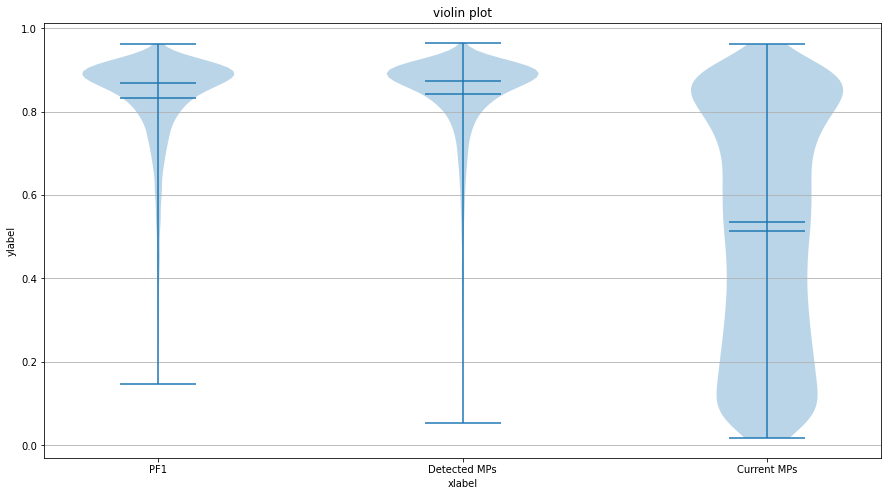

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(15, 8))

#all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]
#
# print(all_p1)
axes.violinplot([all_p1,all_p2,all_p3],
                   showmeans=True,
                   showmedians=True
                   )

axes.set_title('violin plot')

# adding horizontal grid lines

axes.yaxis.grid(True)
#axes.set_xticks([y + 1 for y in range(len(all_data))], )
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')

plt.setp(axes, xticks=[y + 1 for y in range(len([all_p1,all_p2,all_p3]))],
         xticklabels=['PF1', 'Detected MPs', 'Current MPs'],
         )

plt.show()

In [29]:
df_pe1 = pd.DataFrame([['PE1', _] for _ in all_p1],
                     columns=['class', 'prob'])
df_dmp = pd.DataFrame([['Detected_MPs', _] for _ in all_p2],
                     columns=['class', 'prob'])
df_mp = pd.DataFrame([['MPs', _] for _ in all_p3],
                     columns=['class', 'prob'])
df_sns = pd.concat([df_pe1, df_dmp, df_mp], axis=0).reset_index(drop=True)

In [30]:
import seaborn as sns

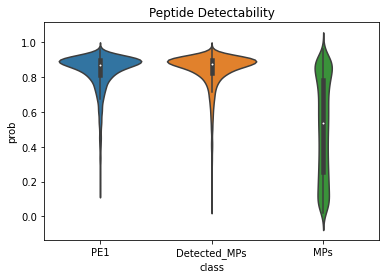

In [31]:
plt.title('Peptide Detectability')
plt.ylabel('Detectability')
plt.xlabel('Type')

sns.violinplot(data=df_sns, x='class', y='prob', order=['PE1', 'Detected_MPs', 'MPs'])
plt.show()